In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

# Clustering Validation - silhouette_score, Calinski-Harabasz Index

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn import metrics
from sklearn.metrics import pairwise_distances

# Clustering Method - Kmean, Hierarchical
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [23]:
# IMPORT: Tableau Superstore dataset
data_path = "../sascha/data/superstore_noid.csv"
df = pd.read_csv(data_path)
# CHANGE: to natural format: non-numeric types

# Type Change: 2 columns -> str
df['Customer ID'] = df['Customer ID'].astype("string")
df['Product ID'] = df['Product ID'].astype("string")

# Type Change: 5 columns -> category 
df['Ship Mode'] = df['Ship Mode'].astype("category")
df['Segment'] = df['Segment'].astype("category")
df['Region'] = df['Region'].astype("category")
df['Category'] = df['Category'].astype("category")
df['Sub-Category'] = df['Sub-Category'].astype("category")

# Type Change: 2 columns -> datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
# DEFINE: column types

id_columns = [
    "Customer ID", "Product ID",
]

# Potential target variables
numeric_columns = [
    "Sales", "Quantity", "Discount", "Profit"
]

category_columns = [
    "Ship Mode", #4
    "Segment", #3
    "Region", #4
    "Category", #3
    "Sub-Category" #17
]

void_columns = [
#    "Row ID", 
   "Order ID", "Country"
]

# Customer Name <-> Customer ID
# Product Name <-> Product ID
# [City, State, Postal Code] <-> Region
redundant_columns = [
    "Customer Name", "Product Name", 
    "City", "State", "Postal Code"
]
# ASSIGN: numeric id instead of string id
# Customer Id -> C_id
# Product Id -> P_id

for i in id_columns:
    df[i[0]+'_id'] = df.groupby(i).ngroup()
# DROP: 10 Columns = id + void + redundant
dropping_columns = id_columns + void_columns + redundant_columns

df_f = df.drop(columns=dropping_columns)
# PROFILE: exploratory analysis & save to HTML - uncomment when needed

# import ydata_profiling as yp

# report_super_f = df_f.profile_report()
# report_super_f.to_file(output_file="0409_super_f_report.html")

### 0. Linear Regression

In [24]:
from sklearn import linear_model

In [28]:
sales_099 = df[['Sales']].quantile(q=0.99, numeric_only=True, interpolation='linear')
sales_001 = df[['Sales']].quantile(q=0.01, numeric_only=True,interpolation='linear')

profit_099 = df[['Profit']].quantile(q=0.99, numeric_only=True,interpolation='linear')
profit_001 = df[['Profit']].quantile(q=0.01, numeric_only=True,interpolation='linear')

no_outlier_df = df[df['Sales']<float(sales_099)]
no_outlier_df = no_outlier_df[no_outlier_df['Sales']>float(sales_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']>float(profit_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']<float(profit_099)]

no_outlier_df= no_outlier_df.reset_index()
df_f = no_outlier_df.drop(columns=dropping_columns)

# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)
# DROP & Standardize: categorical variables


df_f = df_f.drop(category_columns, axis=1)
df_f


,index,Order Date,Ship Date,Sales,Quantity,Discount,Profit,C_id,P_id,0Ship Mode,...,7Sub-Category,8Sub-Category,9Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,15Sub-Category,16Sub-Category
0,0,2016-11-08,2016-11-11,261.960,2,0.0,41.9136,143,12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2016-11-08,2016-11-11,731.940,3,0.0,219.5820,143,55,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2016-06-12,2016-06-16,14.620,2,0.0,6.8714,237,946,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2015-10-11,2015-10-18,22.368,2,0.2,2.5164,705,1316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,2014-06-09,2014-06-14,48.860,7,0.0,14.1694,88,185,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,9989,2014-01-21,2014-01-23,25.248,3,0.2,4.1028,737,200,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9661,9990,2017-02-26,2017-03-03,91.960,2,0.0,15.6332,190,164,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9662,9991,2017-02-26,2017-03-03,258.576,2,0.2,19.3932,190,1816,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9663,9992,2017-02-26,2017-03-03,29.600,4,0.0,13.3200,190,1247,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [29]:
columns_to_drop = [
    "Order Date",
    "Ship Date",
    "C_id",
    "P_id"
]

# Drop the specified columns
df_cleaned = df_f.drop(columns=columns_to_drop)

#df_cleaned
df_cleaned[["Profit"]]
df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]

,0Category,0Region,0Segment,0Ship Mode,0Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,...,3Sub-Category,4Sub-Category,5Sub-Category,6Sub-Category,7Sub-Category,8Sub-Category,9Sub-Category,Discount,Quantity,Sales
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,261.960
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,731.940
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,14.620
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,2,22.368
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,48.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,3,25.248
9661,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,91.960
9662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,2,258.576
9663,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,29.600


In [33]:
X = df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]
y = df_cleaned[["Profit"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = reg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 2382.22
Coefficient of determination: 0.54


### 1. Product - Sales, Quantity

In [3]:
columns_to_drop = [
    "Order ID",
    "Ship Date",
    "Ship Mode",
    "Customer ID",
    "Customer Name",
    "Segment",
    "Country",
    "City",
    "State",
    "Postal Code",
    "Region",
    "Sub-Category",
    "Product Name",
    "Discount",
    "Profit",
    "Order Date",
]

# Drop the specified columns
df_cleaned = df.drop(columns=columns_to_drop)

# Group by 'Product ID' and sum the 'Sales' and 'Quantity' columns
grouped_df = df_cleaned.groupby("Product ID", as_index=False).agg({"Sales": "sum", "Quantity": "sum"})

data = grouped_df[["Sales", "Quantity"]]

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(normalized_data)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(normalized_data)

# Add the cluster labels back to the original data
grouped_df["KMeans_Cluster"] = kmeans_labels
grouped_df["DBSCAN_Cluster"] = dbscan_labels

# Display the dataframe with added cluster labels
print(grouped_df.head())

        Product ID     Sales  Quantity  KMeans_Cluster  DBSCAN_Cluster
0  FUR-BO-10000112   825.174         9               0               0
1  FUR-BO-10000330  1064.624        10               0               0
2  FUR-BO-10000362  2154.348        14               0               0
3  FUR-BO-10000468   723.842        21               0               0
4  FUR-BO-10000711   851.760        12               0               0


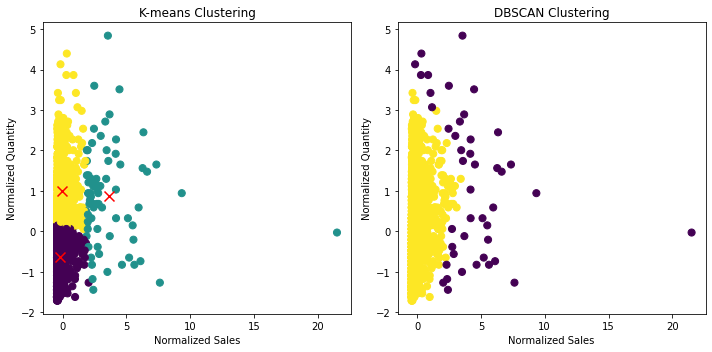

In [4]:
# Plot K-means clusters
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title('K-means Clustering')
plt.xlabel('Normalized Sales')
plt.ylabel('Normalized Quantity')

# Plot DBSCAN clusters
plt.subplot(1, 2, 2)
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Normalized Sales')
plt.ylabel('Normalized Quantity')

plt.tight_layout()
plt.show()

### 2. Product - Sales, Quantity, Discount, Profit, Category

In [101]:
columns_drop = [
    "Order ID",
    "Ship Date",
    "Ship Mode",
    "Customer ID",
    "Customer Name",
    "Segment",
    "Country",
    "City",
    "State",
    "Postal Code",
    "Region",
    "Sub-Category",
    "Product Name",
    "Order Date",
]
df_cleaned = df.drop(columns=columns_drop)

df_cleaned['Discount Amount'] = df_cleaned['Sales'] * df_cleaned['Discount']
grouped_df = df_cleaned.groupby(['Product ID', 'Category']).agg(
    {
        'Sales': 'sum',
        'Quantity': 'sum',
        'Discount Amount': 'sum',
        'Profit': 'sum',
    }
).reset_index()

# One-hot encode Category
grouped_df_encoded = pd.get_dummies(grouped_df, columns=['Category'])

# Normalize the numerical attributes
scaler = StandardScaler()
numeric_columns = ['Sales', 'Quantity', 'Discount Amount', 'Profit']
grouped_df_encoded[numeric_columns] = scaler.fit_transform(grouped_df_encoded[numeric_columns])

# Perform K-means clustering
kmean = KMeans(n_clusters=4, random_state=42)
grouped_df_encoded['Cluster'] = kmean.fit_predict(grouped_df_encoded.iloc[:, 1:])

# Add cluster labels back to the original dataframe
grouped_df['Cluster'] = grouped_df_encoded['Cluster']


In [102]:
grouped_df

,Product ID,Category,Sales,Quantity,Discount Amount,Profit,Cluster
0,FUR-BO-10000112,Furniture,825.174,9,247.5522,-117.8820,0
1,FUR-BO-10000112,Office Supplies,0.000,0,0.0000,0.0000,0
2,FUR-BO-10000112,Technology,0.000,0,0.0000,0.0000,0
3,FUR-BO-10000330,Furniture,1064.624,10,123.3996,24.1960,0
4,FUR-BO-10000330,Office Supplies,0.000,0,0.0000,0.0000,0
...,...,...,...,...,...,...,...
5581,TEC-PH-10004959,Office Supplies,0.000,0,0.0000,0.0000,0
5582,TEC-PH-10004959,Technology,341.666,4,48.2352,40.1960,0
5583,TEC-PH-10004977,Furniture,0.000,0,0.0000,0.0000,0
5584,TEC-PH-10004977,Office Supplies,0.000,0,0.0000,0.0000,0


In [103]:
df_cluster = df.copy(deep=True)

df_cluster.loc[df_cluster['Product ID'].isin(list(grouped_df.loc[grouped_df['Cluster'] == 0]['Product ID'])), 'Cluster'] = int(0)
df_cluster.loc[df_cluster['Product ID'].isin(list(grouped_df.loc[grouped_df['Cluster'] == 1]['Product ID'])), 'Cluster'] = int(1)
df_cluster.loc[df_cluster['Product ID'].isin(list(grouped_df.loc[grouped_df['Cluster'] == 2]['Product ID'])), 'Cluster'] = int(2)
df_cluster.loc[df_cluster['Product ID'].isin(list(grouped_df.loc[grouped_df['Cluster'] == 3]['Product ID'])), 'Cluster'] = int(3)

In [104]:
no_outlier_df = df_cluster[df_cluster['Sales']<float(sales_099)]
no_outlier_df = no_outlier_df[no_outlier_df['Sales']>float(sales_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']>float(profit_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']<float(profit_099)]

no_outlier_df = no_outlier_df.reset_index()
df_f = no_outlier_df.drop(columns=dropping_columns)

# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)
# DROP & Standardize: categorical variables


df_f = df_f.drop(category_columns, axis=1)

columns_to_drop = [
    "Order Date",
    "Ship Date",
    "C_id",
    "P_id"
]

# Drop the specified columns
df_cleaned = df_f.drop(columns=columns_to_drop)

#df_cleaned
df_cleaned[["Profit"]]
df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]

,0Category,0Region,0Segment,0Ship Mode,0Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,...,4Sub-Category,5Sub-Category,6Sub-Category,7Sub-Category,8Sub-Category,9Sub-Category,Cluster,Discount,Quantity,Sales
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,261.960
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,3,731.940
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,14.620
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,2,22.368
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,7,48.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.2,3,25.248
9661,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2,91.960
9662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,2,258.576
9663,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,29.600


In [105]:
X = df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]
y = df_cleaned[["Profit"]]

X0 = X.loc[X['Cluster'] == 0]
y0 = df_cleaned[["Profit"]].loc[X['Cluster'] == 0]
X1 = X.loc[X['Cluster'] == 1]
y1 = df_cleaned[["Profit"]].loc[X['Cluster'] == 1]
X2 = X.loc[X['Cluster'] == 2]
y2 = df_cleaned[["Profit"]].loc[X['Cluster'] == 2]
X3 = X.loc[X['Cluster'] == 3]
y3 = df_cleaned[["Profit"]].loc[X['Cluster'] == 3]

In [106]:
X3

,0Category,0Region,0Segment,0Ship Mode,0Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,...,4Sub-Category,5Sub-Category,6Sub-Category,7Sub-Category,8Sub-Category,9Sub-Category,Cluster,Discount,Quantity,Sales
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.00,3,731.9400
9,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.20,9,1706.1840
23,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,3,1044.6300
36,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.32,3,532.3992
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.70,1,157.7940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9462,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.32,5,1023.3320
9463,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.30,3,600.5580
9549,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.20,4,848.5440
9572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.40,1,330.5880


In [107]:
reg0 = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.2, random_state=42)
reg0.fit(X_train, y_train)
y_pred = reg0.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


reg1 = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
reg1.fit(X_train, y_train)
y_pred = reg1.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


reg2 = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
reg2.fit(X_train, y_train)
y_pred = reg2.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


reg3 = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
reg3.fit(X_train, y_train)
y_pred = reg3.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 1503.96
Coefficient of determination: 0.49
Mean squared error: 1855.58
Coefficient of determination: 0.60


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### 3. Customer - Recency, Frequency, Monetary

In [122]:
# Calculate Recency, Frequency, and Monetary (RFM) values
snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'count',
    'Sales': 'sum'
}).rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Monetary'
})

# Normalize RFM values and apply K-means clustering
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm)
Spectral = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = Spectral.fit_predict(rfm_normalized)

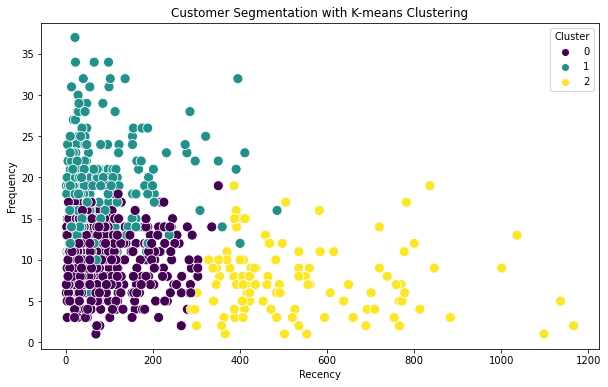

In [123]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segmentation with K-means Clustering')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

In [124]:
rfm.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
AA-10315,185,11,5563.560,1
AA-10375,20,15,1056.390,0
AA-10480,260,12,1790.512,0
AA-10645,56,18,5086.935,1
AB-10015,416,6,886.156,2


In [125]:
df_cluster = df.copy(deep=True)

df_cluster.loc[df_cluster['Customer ID'].isin(list(rfm.loc[rfm['Cluster'] == 0].index.values)), 'Cluster'] = int(0)
df_cluster.loc[df_cluster['Customer ID'].isin(list(rfm.loc[rfm['Cluster'] == 1].index.values)), 'Cluster'] = int(1)
df_cluster.loc[df_cluster['Customer ID'].isin(list(rfm.loc[rfm['Cluster'] == 2].index.values)), 'Cluster'] = int(2)

In [126]:
df_cluster

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,C_id,P_id,Cluster
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,143,12,2.0
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,143,55,2.0
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,237,946,0.0
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,705,319,0.0
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,705,1316,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,...,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028,737,200,1.0
9990,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,...,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332,190,164,0.0
9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,...,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932,190,1816,0.0
9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,...,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200,190,1247,0.0


In [127]:
no_outlier_df = df_cluster[df_cluster['Sales']<float(sales_099)]
no_outlier_df = no_outlier_df[no_outlier_df['Sales']>float(sales_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']>float(profit_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']<float(profit_099)]

no_outlier_df = no_outlier_df.reset_index()
df_f = no_outlier_df.drop(columns=dropping_columns)

# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)
# DROP & Standardize: categorical variables


df_f = df_f.drop(category_columns, axis=1)

columns_to_drop = [
    "Order Date",
    "Ship Date",
    "C_id",
    "P_id"
]

# Drop the specified columns
df_cleaned = df_f.drop(columns=columns_to_drop)

#df_cleaned
df_cleaned[["Profit"]]
df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]

,0Category,0Region,0Segment,0Ship Mode,0Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,...,4Sub-Category,5Sub-Category,6Sub-Category,7Sub-Category,8Sub-Category,9Sub-Category,Cluster,Discount,Quantity,Sales
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2,261.960
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,3,731.940
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,14.620
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,2,22.368
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,7,48.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.2,3,25.248
9661,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,91.960
9662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,2,258.576
9663,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,29.600


In [128]:
X = df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]
y = df_cleaned[["Profit"]]

X0 = X.loc[X['Cluster'] == 0]
y0 = df_cleaned[["Profit"]].loc[X['Cluster'] == 0]
X1 = X.loc[X['Cluster'] == 1]
y1 = df_cleaned[["Profit"]].loc[X['Cluster'] == 1]
X2 = X.loc[X['Cluster'] == 2]
y2 = df_cleaned[["Profit"]].loc[X['Cluster'] == 2]

In [129]:
reg0 = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.2, random_state=42)
reg0.fit(X_train, y_train)
y_pred = reg0.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 2401.66
Coefficient of determination: 0.50


In [130]:
reg1 = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
reg1.fit(X_train, y_train)
y_pred = reg1.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 2737.51
Coefficient of determination: 0.52


In [131]:
reg2 = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
reg2.fit(X_train, y_train)
y_pred = reg2.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 2258.91
Coefficient of determination: 0.35


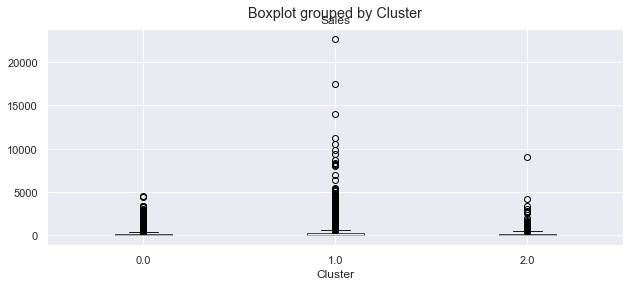

In [30]:
boxplot = df_cluster.boxplot(column = ['Sales'], by='Cluster', layout=(1,1), figsize=(10,4))

Cluster 1 shows relatively high sales than Cluster 0

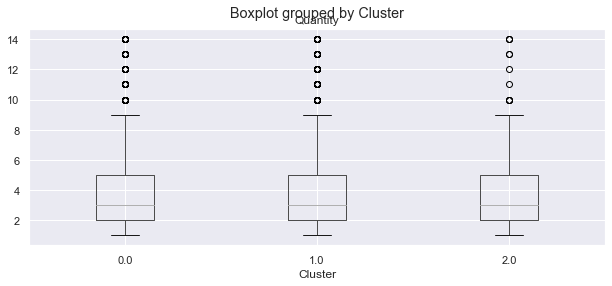

In [31]:
boxplot = df_cluster.boxplot(column = ['Quantity'], by='Cluster', layout=(1,1), figsize=(10,4))

However, there were no significant differences in quantity
 --> people in the cluster 1 purchase more expensive products (than cluster 0 people)

 (Not related to the frequency. I drew the graph based on df data(per order data))
 (Nevertheless, according to the above graph, it is still true that cluster 1 shows higher frequency than cluster 0)

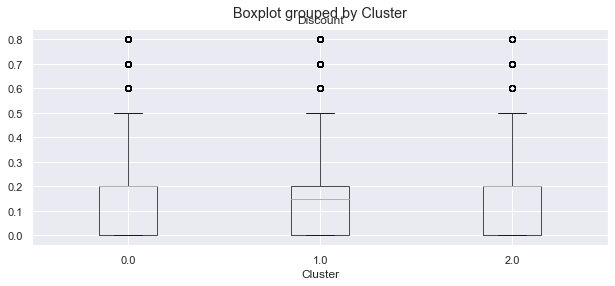

In [33]:
boxplot = df_cluster.boxplot(column = ['Discount'], by='Cluster', layout=(1,1), figsize=(10,4))

Also, people in the cluster 1 tend to provide more discount (median)
--> maybe, this is somehow related to the cluster 1 tendency(purchase more expensive products, more frequently)

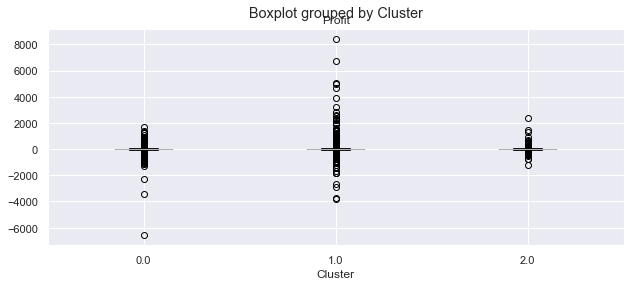

In [32]:
boxplot = df_cluster.boxplot(column = ['Profit'], by='Cluster', layout=(1,1), figsize=(10,4))

As a result, Profit variation of cluster 1 is very large (high sales+high discount)

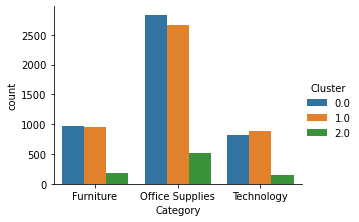

In [15]:
sns.catplot(kind='count', data=df_cluster, x='Category', hue='Cluster', height=3, aspect=1.4)
plt.show()

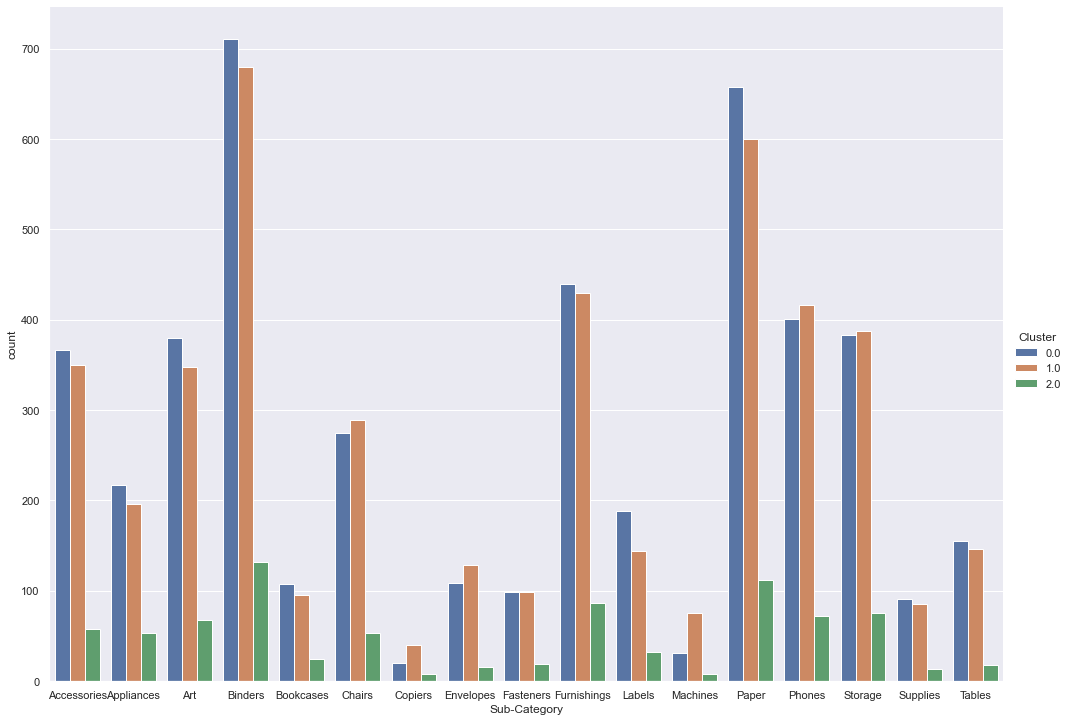

In [42]:
sns.catplot(kind='count', data=df_cluster, x='Sub-Category', hue='Cluster', height=10, aspect=1.4)
plt.show()

People in cluster 1(people who buy expensive products prequently) tend to buy Chairs / Copiers / Envelopes / Machines / Phones/ Storages more than others
(Interpretating reasons coincide with other results might be meaningful)

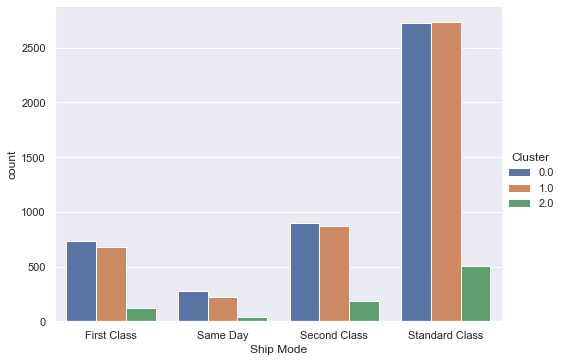

In [36]:
sns.catplot(kind='count', data=df_cluster, x='Ship Mode', hue='Cluster', height=5, aspect=1.4)
plt.show()

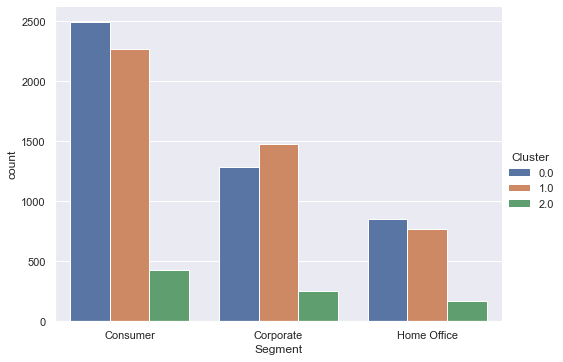

In [37]:
sns.catplot(kind='count', data=df_cluster, x='Segment', hue='Cluster', height=5, aspect=1.4)
plt.show()

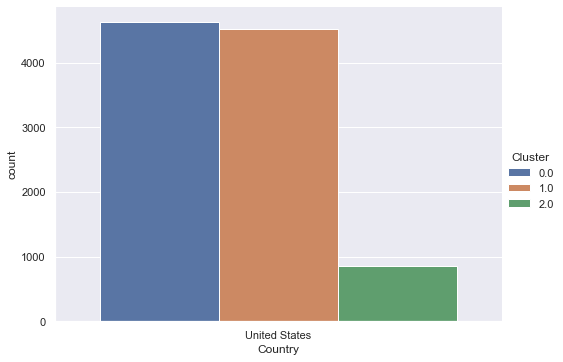

In [38]:
#sns.catplot(kind='count', data=df_cluster, x='Country', hue='Cluster', height=5, aspect=1.4)
#plt.show()

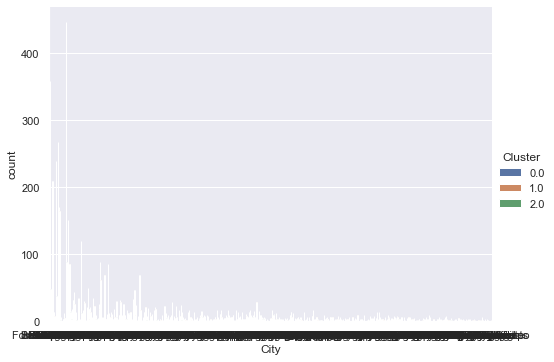

In [39]:
#sns.catplot(kind='count', data=df_cluster, x='City', hue='Cluster', height=5, aspect=1.4)
#plt.show()

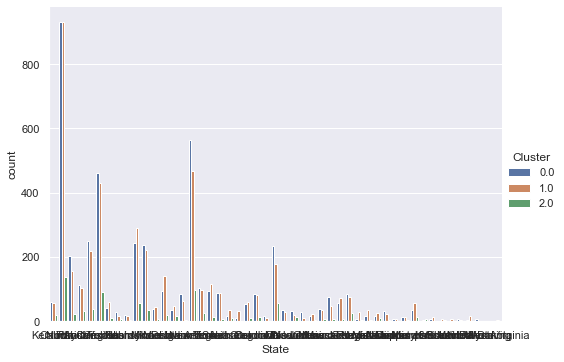

In [40]:
#sns.catplot(kind='count', data=df_cluster, x='State', hue='Cluster', height=5, aspect=1.4)
#plt.show()

Limitation:

because of the low amount of cluster 2, I couldn't take closer look on cluster 2.

Lather than giving up cluster 2 people(once he perchased, do not order again), analysing the reasons why they don't order again might be meaningful.